In [1]:
# mount your own google drive
from google.colab import drive
drive.mount('/content/drive')

# change working directory 
%cd /content/drive/My Drive/Assignment2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Assignment2


# 1. Model Training and Testing

In [2]:
import pandas as pd

# read CSV file into a pandas DataFrame
df = pd.read_csv('cuisine_df.csv')
print("Number of rows:", len(df))
print(df.head())

# Print the number of unique values in the 'id' and 'objectID' columns
print("Unique values in 'id':", df['id'].nunique())


Number of rows: 4186
        id   cuisine
0  1956014    French
1  2640075    French
2  1955135  Japanese
3  2638290    French
4  1869678    French
Unique values in 'id': 4186


In [ ]:
# Do not have to download every time
!wget "http://seppe.net/aa/assignment2/images.zip"

--2023-05-19 22:02:54--  http://seppe.net/aa/assignment2/images.zip
Resolving seppe.net (seppe.net)... 37.139.1.16
Connecting to seppe.net (seppe.net)|37.139.1.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21223409265 (20G) [application/zip]
Saving to: ‘images.zip.1’

images.zip.1        100%[===================>]  19.77G  29.3MB/s    in 10m 11s 

2023-05-19 22:13:05 (33.1 MB/s) - ‘images.zip.1’ saved [21223409265/21223409265]



In [3]:
# Package: to add a progress bar to the upzip processing.
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from tqdm.notebook import tqdm_notebook as tqdm
import os

# convert id into str list, it defines what id(images) we need to extract 
file_ids = list(df['id'].astype(str))
# List of file extensions that we want to handle
file_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".eps", 
                   ".raw", ".indd", ".ai", ".pdf", ".svg", ".webp"]
# Initialize command
command = '7z x images.zip '
for i, file_id in enumerate(tqdm(file_ids, desc="Unzipping files")):
    # Generate a command for each file extension
    for ext in file_extensions:
        command += f"-ir!{file_id}{ext} "
    # limit the command length to prevent overloading the system command
    if i % 500 == 0 and i > 0:  # choose an appropriate frequency to execute the command
        os.system(command)
        command = '7z x images.zip '  # reset the command
# Handle the remaining files
if len(file_ids) % 500 != 0:  
    os.system(command)


Unzipping files:   0%|          | 0/4186 [00:00<?, ?it/s]

In [5]:
# install package for model training
!install keras

install: missing destination file operand after 'keras'
Try 'install --help' for more information.


In [6]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import glob

# define path to images and csv file (contain id and target)
images_dir = 'images/'
csv_file_path = 'cuisine_df.csv'
# read csv file
df = pd.read_csv(csv_file_path)

# List of file extensions that we want to handle
file_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".eps", 
                   ".raw", ".indd", ".ai", ".pdf", ".svg", ".webp"]
# extract id and label for images (here, id and cuisine)
X = []
y = []
for index, row in df.iterrows():
    # Check each file extension
    for ext in file_extensions:
        img_file_path = os.path.join(images_dir, str(row['id']) + ext)
        if os.path.exists(img_file_path):
            img = cv2.imread(img_file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR to RGB
            img = cv2.resize(img, (128, 128))
            X.append(img)
            y.append(row['cuisine'])
            break  # If image file was found, move to the next row

# encoding target class
classes = ['Chinese', 'French', 'Italian', 'Japanese','Other']
y = [classes.index(label) for label in y]

# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# convert image data to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Check the size of the train and test data
print('Train data size:', X_train.shape[0])
print('Test data size:', X_test.shape[0])

Train data size: 2291
Test data size: 982


In [7]:
# CNN model training
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.005))) # we have 5 classes 

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model fitting
history = model.fit(X_train, y_train, epochs=15, batch_size=40, validation_data=(X_test, y_test))

# model evaluation
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Train loss:', train_loss)
print('Train accuracy:', train_acc)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


Epoch 1/15
58/58 [==============================] - 104s 2s/step - loss: 11.9138 - accuracy: 0.2492 - val_loss: 2.8143 - val_accuracy: 0.2811
Epoch 2/15
58/58 [==============================] - 100s 2s/step - loss: 2.7365 - accuracy: 0.2885 - val_loss: 2.6899 - val_accuracy: 0.2607
Epoch 3/15
58/58 [==============================] - 99s 2s/step - loss: 2.6274 - accuracy: 0.3051 - val_loss: 2.6163 - val_accuracy: 0.3035
Epoch 4/15
58/58 [==============================] - 113s 2s/step - loss: 2.5603 - accuracy: 0.3291 - val_loss: 2.5516 - val_accuracy: 0.3065
Epoch 5/15
58/58 [==============================] - 98s 2s/step - loss: 2.4553 - accuracy: 0.3387 - val_loss: 2.5246 - val_accuracy: 0.3065
Epoch 6/15
58/58 [==============================] - 99s 2s/step - loss: 2.3809 - accuracy: 0.3627 - val_loss: 2.5369 - val_accuracy: 0.3014
Epoch 7/15
58/58 [==============================] - 99s 2s/step - loss: 2.2807 - accuracy: 0.3981 - val_loss: 2.5769 - val_accuracy: 0.2851
Epoch 8/15
58/58

31/31 [==============================] - 11s 347ms/step


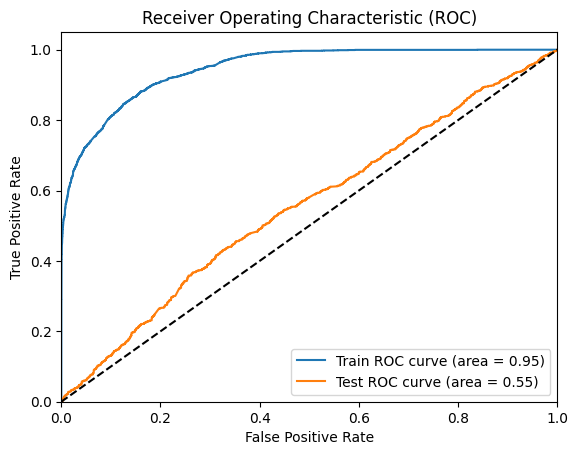

In [8]:
# AUC 
y_train_pred = model.predict(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train.ravel(), y_train_pred.ravel())
auc_train = auc(fpr_train, tpr_train)

y_test_pred = model.predict(X_test)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test.ravel(), y_test_pred.ravel())
auc_test = auc(fpr_test, tpr_test)

# ROC Plot
import matplotlib.pyplot as plt
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], 'k--') # 对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [9]:
# save model as .h5 file
model.save('cuisine_model.h5')


2. Model Interpretation

1/1 [==============================] - 0s 47ms/step
Predicted class: Chinese


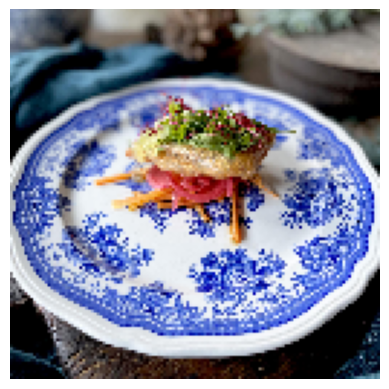

In [52]:
# Reshape the input image to match the model's expected input shape
input_image = X_test[68].reshape(1, 128, 128, 3)

# Perform the prediction
prediction = model.predict(input_image)

# Get the predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class = classes[predicted_class_index]

print('Predicted class:', predicted_class)

# Display the input image
plt.imshow(X_test[68])
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 95ms/step
Visualizing feature maps of layer 1


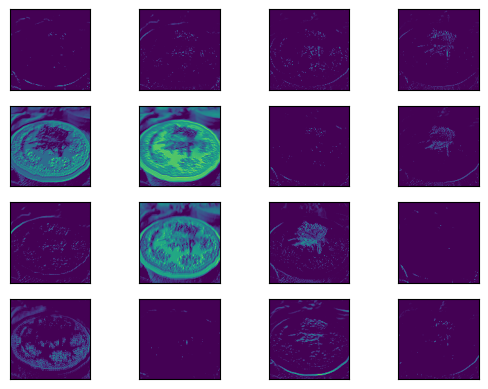

Visualizing feature maps of layer 2


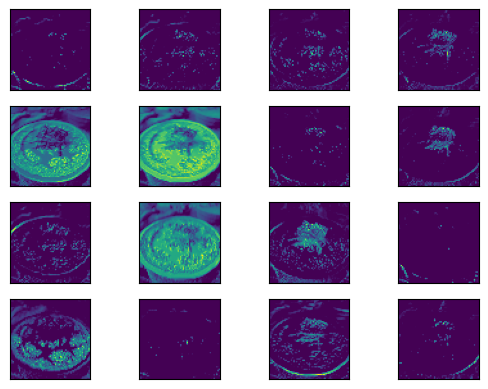

Visualizing feature maps of layer 3


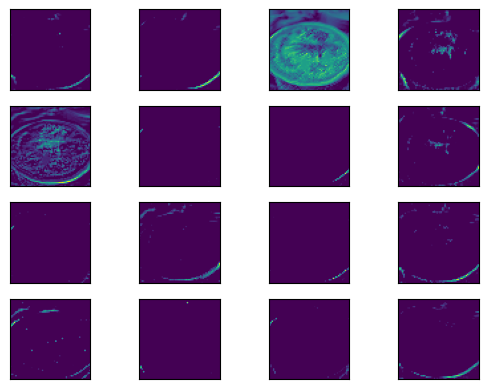

Visualizing feature maps of layer 4


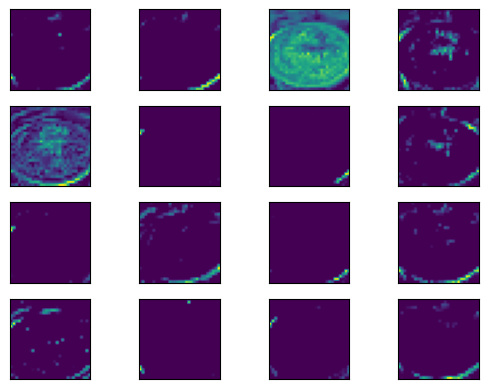

Visualizing feature maps of layer 5


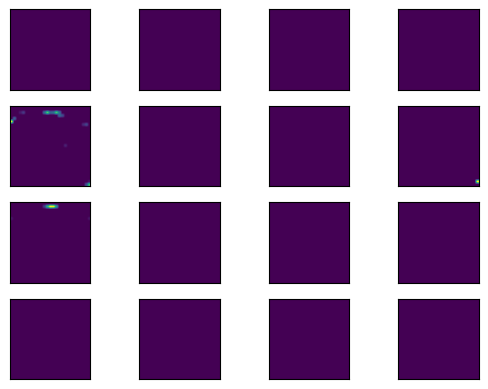

Visualizing feature maps of layer 6


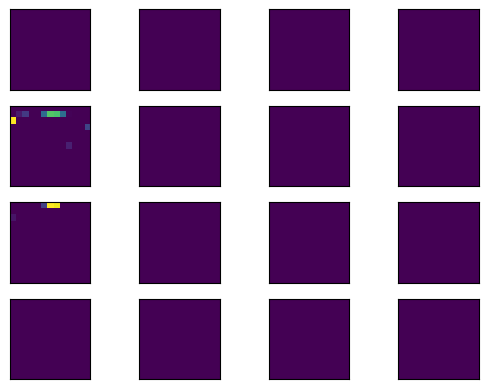

In [54]:
# Conduct model interpretation using feature map
from keras.models import Model
import matplotlib.pyplot as plt

# Select the layers for which to visualize feature maps
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]

# Create a model that will return these outputs, given the model input
feature_map_model = Model(inputs=model.inputs, outputs=layer_outputs)

# Run prediction for the first image in the test set
img = X_test[68]  # Select one of your input images. Here, we are just using the first one.
img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])  # Model expects 4D input (batch of images). Reshape single image to have batch size of 1.

# Generate the feature maps for this image
feature_maps = feature_map_model.predict(img)

# Now let's visualize the feature maps
for layer_num, fmap in enumerate(feature_maps):
    print(f'Visualizing feature maps of layer {layer_num + 1}')
    ix = 1
    for _ in range(4):  # Assuming your feature maps are 3D and we can get an 4x4 grid of images
        for _ in range(4):
            # Ensure we have enough feature maps to display a grid
            if fmap.shape[-1] >= ix:
                ax = plt.subplot(4, 4, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')  # fmap[0, :, :, ix-1] selects the correct feature map from the batch
                ix += 1
    plt.show()
